# Import

- fix shoreline
- add more septics
- 1965 images
- flux

In [1]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pathlib import Path

from datetime import datetime
from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import os
import platform
import subprocess
from shapely.geometry import Polygon, Point
from scipy.interpolate import make_interp_spline
from random_name import generate_random_name


In [2]:
def locate_ground_surface_lay(row=150):
    cross_section = ibound[:,:,0]
    lay = np.where(cross_section[:,row]==1)[0][0]
    return lay

def meter_to_col(col_meter):
    return int(np.round(col_meter/delc,0))

def meter_to_row(row_meter):
    return int(np.round(row_meter/delc,0))

def meter_to_lay(lay_meter):
    return int(np.round((top_elev-lay_meter)/layer_thickness,0))

def col_to_meter(col):
    return col*delc

def row_to_meter(row):
    return row*delc

def lay_to_meter(row):
    return 190.0-row*layer_thickness

In [3]:

def change_array_within_polygon(array, row_coords, col_coords, value):

    # Create a polygon object from the row and column coordinates
    polygon = Polygon(zip(col_coords, row_coords))

    # Create a boolean mask indicating which points fall within the polygon
    mask = np.zeros_like(array, dtype=bool)
    for row in range(array.shape[0]):
        for col in range(array.shape[1]):
            point = Point(col, row)
            if polygon.contains(point) or polygon.intersects(point):
                mask[row, col] = True

    # Set the values of the array that fall within the polygon to the new value
    array[mask] = value

    return array


# Workspace

In [4]:

# Control variable to decide the location of the temp folder
use_d_drive = True  # Set to True to use the custom location

# Define model workspace
myt = datetime.now().strftime('%m%d%H%M%S')
name = 'wasaga'
adj_non = '_' + generate_random_name()

if use_d_drive and platform.system() == 'Windows':  # Check if on Windows
    temp_dir = 'H:/mf/_T{}_{}'.format(myt, adj_non)  # Path for D drive
elif use_d_drive and platform.system() == 'Darwin':  # Check if on macOS
    temp_dir = '/Volumes/Public/mf/_T{}_{}'.format(myt, adj_non)
else:
    temp_dir = mkdtemp(prefix='_T{}_'.format(myt), suffix=adj_non)

os.makedirs(Path(temp_dir) / '_output', exist_ok=True)
model_ws = temp_dir





In [ ]:
def open_file(path):
    if platform.system() == "Windows":
        os.startfile(path)
    elif platform.system() == "Darwin":
        subprocess.Popen(["open", path])
    else:
        subprocess.Popen(["xdg-open", path])

open_file(model_ws)

In [ ]:
# base
parms= {}
parms['sp1']= 0.0002
parms['hk']= 6.9
parms['al'] = 5
base_parms = parms

# Model

In [ ]:
# Create a MODFLOW model instance
mf = flopy.modflow.Modflow(modelname="example_model",version='mf2005',
                              exe_name='mf2005', 
                              model_ws=model_ws)

In [ ]:
# # Create a MODFLOW model instance
# model = flopy.seawat.Seawat(modelname="example_model",
#                             exe_name='swtv4', 
#                               model_ws=model_ws)


# DIS

In [ ]:
# Define model dimensions
nlay = int(60 * 2)
nrow = int(220 * 2)
ncol = int(220 * 2)
delr = 2200/nrow  # Cell width along rows (extend 2200 / 220)
delc = 2200/ncol  # Cell width along columns (extend 2200 / 220)

# Define top elevation
layer_thickness = 30.0 / nlay

top_elev = 190.0
botm_elev = [top_elev - (i * layer_thickness) for i in range(1, nlay + 1)]
# Define layer thickness (uniform thickness)


perlen = 365
nper = int(200)
#nper = int(56)
#nper = int(500)

steady = np.append(np.array([True]),np.repeat(False,nper-1))
#steady=[False,False,True]
#steady = True

# Create DIS package



In [ ]:
dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=delr, delc=delc,top=top_elev, 
                               botm=botm_elev,
                               nper = nper, perlen = perlen,
                               nstp = 1, steady = steady)


# Ibound

In [ ]:


# Manually typed dictionary with values
data_dict = {
    0: [0, 190, 185], 1: [100, 190, 184], 2: [340, 187, 180], 3: [600, 184, 175], 4: [750, 184, 174],
    5: [850, 184, 174], 6: [1100-40, 183, 173], 7: [1350-60, 182-0.5, 170], 8: [1480-50, 181.5-0.5, 169], 9: [1590-60, 178.5-0.3, 168.5],
    10: [1630-50, 174.2+1, 167.5], 11: [1690+50, 173.5+0.5, 167.5], 12: [1790+50, 173.2+0.5, 166.8], 13: [1850+50, 173.0+0.5, 166.5],
    14: [2050, 172.5+0.5, 165], 15: [2200, 171.5+0.5, 164]
}

# Extracting lists from the dictionary
x, y_topo, y_clay = zip(*data_dict.values())

# Convert to numpy arrays if necessary
x, y_topo, y_clay = map(np.array, (x, y_topo, y_clay))


#t = np.array(x[0:1].tolist()*2+ x.tolist() + x[-1:].tolist()*2)

# Interpolate the data using smoothing splines
spl = make_interp_spline(x, y_topo,k=2)
x_smooth_topo = np.linspace(x.min(), x.max(), 30)
y_smooth_topo = spl(x_smooth_topo)

col_coords = (x_smooth_topo/delr).round(0)
col_coords_topo = list(col_coords) +[nrow,0]

row_coords = ((top_elev - y_smooth_topo)/layer_thickness).round(0)
row_coords_topo  =  list(row_coords) +[0,0]


# Interpolate the data using smoothing splines
spl = make_interp_spline(x, y_clay)
x_smooth = np.linspace(x.min(), x.max(), 30)
y_smooth = spl(x_smooth)

col_coords = (x_smooth/delr).round(0)
col_coords_clay = list(col_coords) +[nrow,0]
row_coords = ((top_elev - y_smooth)/layer_thickness).round(0)
row_coords_clay  =  list(row_coords) +[nlay,nlay]


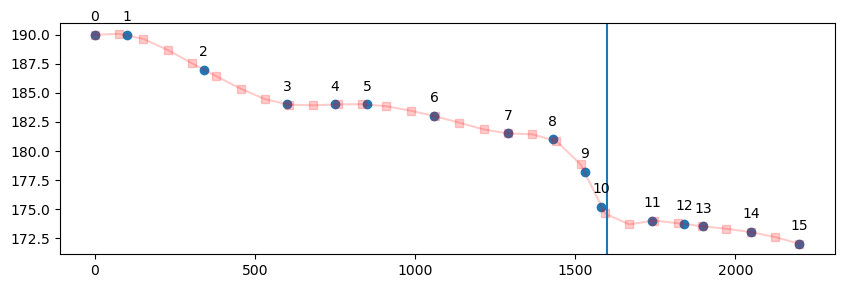

In [ ]:
shoreline_distance = 1600

# Plotting the smoothed line

plt.plot(x_smooth_topo, y_smooth_topo, c='r', marker='s', alpha=0.2)

# Scatter plot of the original data
plt.scatter(x, y_topo)

# Adding ordinal annotations to each scattered point
for i, (xi, yi) in enumerate(zip(x, y_topo), start=0):
    ordinal = "{}".format(i)
    plt.annotate(ordinal, (xi, yi), textcoords="offset points", xytext=(0,10), ha='center')

# Setting the size of the figure
plt.gcf().set_size_inches(10, 3)

plt.axvline(x=shoreline_distance)

plt.show()


# Ibound & Strt

174.25


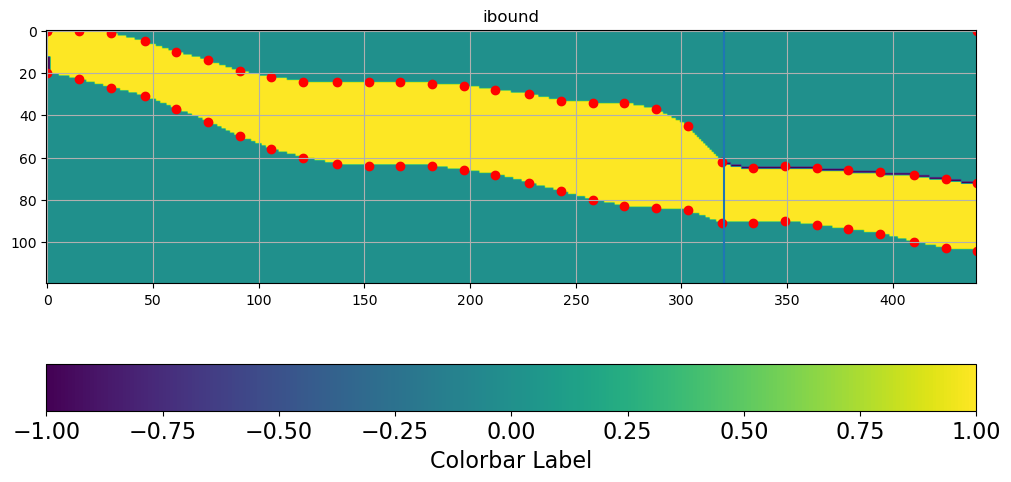

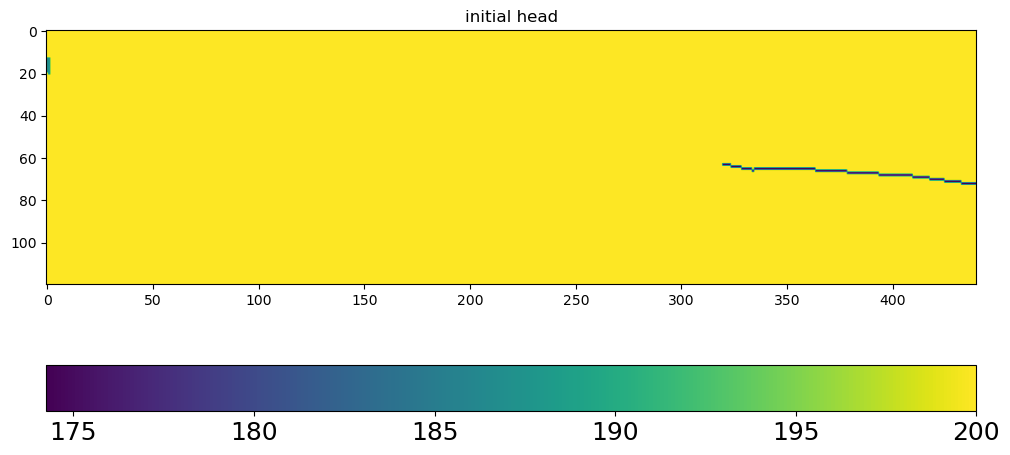

In [ ]:

# Define ibound and initial conditionsa
ibound = np.ones((nlay, nrow, ncol), dtype=int)
initial_head = np.full((nlay, nrow, ncol), 200.0, dtype=float)
shoreline_distance = 1600

# Set constant head boundary conditions for the first and last rows
array = change_array_within_polygon(ibound, row_coords_topo, col_coords_topo, 0)
plt.scatter(col_coords_topo,row_coords_topo,c='r')


array = change_array_within_polygon(ibound, row_coords_clay, col_coords_clay, 0)
plt.scatter(col_coords,row_coords,c='r')

for c in range(0,2):
    i = np.where(ibound[:,c,-1]==1)[0][-1]
    head = top_elev-i*layer_thickness
    
    while head<187:
        ibound[i,c,:] = -1
        initial_head[i,c,:] = 187
        head+=layer_thickness
        i-=1


lay = np.where(ibound[:,int(shoreline_distance/delr),-1])[0][0]
elv = lay_to_meter(lay)
head = elv
print(elv)

for c in range(int(shoreline_distance/delr),int(2200/delr)):
    lay = np.where(ibound[:,c,-1]==1)[0][0]
    #print(lay,lay_to_meter(lay))
    ibound[lay,c,:] = -1
    
    initial_head[lay,c,:] = elv

# Your existing code
im = plt.imshow(ibound[:,:,2], origin='upper', aspect=1)
plt.axvline(x=meter_to_col(shoreline_distance))# shoreline
plt.gcf().set_size_inches(12,7)


cbar = plt.colorbar(im, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Colorbar Label', fontsize=16)

# Display the plot
plt.title('ibound')
plt.grid()
plt.show()


fig, ax = plt.subplots(figsize=(12, 7))
im = ax.imshow(initial_head[:, :, 0], origin='upper')

# Add a horizontal colorbar
cbar = plt.colorbar(im, orientation='horizontal')
cbar.ax.tick_params(labelsize=18)
plt.title('initial head')
plt.show()


# BAS LPF  PCG

In [ ]:

# Create BAS package
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=initial_head)

# Define hydraulic properties
horizontal_k = parms['hk'] # Horizontal hydraulic conductivity (m/day)
vertical_ka = 0.1   # Vertical hydraulic conductivity (m/day)
porosity = 0.25     # Porosity

# Create LPF package (Layer Property Flow package)
lpf = flopy.modflow.ModflowLpf(mf, hk=horizontal_k, 
                               vka=vertical_ka, laytyp=1, 
                               ipakcb=None,ss=0.0002,sy=0.33,
                               laywet=1,iwetit=5,wetfct=0.1,ihdwet=0,iwdflg=1,wetdry=-0.25)

# #ss=0.0002,sy=0.33
# upw = flopy.modflow.ModflowUpw(model, laytyp=1, hk=horizontal_k)

# pcg = flopy.modflow.ModflowPcg(mf, hclose=1e-3,npcond=1,
#                                relax=0.99,rclose=1e-3,mutpcg=1,nbpol=1,iprpcg=1,
#                                mxiter=100,iter1=60)


pcg = flopy.modflow.ModflowPcg(mf, hclose=1e-3,npcond=1,
                               relax=0.98,rclose=1e-4,mutpcg=0,nbpol=0,iprpcg=0,
                               mxiter=200,iter1=120, damp=0.95)

#

# DRN

In [ ]:
# # Assuming necessary variables (shoreline_distance, delr, ncol, nrow, nlay, ibound) are defined
# start_dis_1 = shoreline_distance - 150
# end_dis_1 = shoreline_distance - 60
# start_dis_2 = 595
# end_dis_2 = 610

# drn_list = []

# # Function to check for inactive neighbor cells
# def has_inactive_neighbor(lay, row, col):
#     for dlay, drow, dcol in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]:
#         n_lay, n_row, n_col = lay + dlay, row + drow, col + dcol
#         if 0 <= n_lay < nlay and 0 <= n_row < nrow and 0 <= n_col < ncol:
#             if ibound[n_lay, n_row, n_col] == 0:
#                 return True
#     return False


# # Function to add drainage cells within a given range
# def add_drainage_cells(start_m, end_m):
#     for row in range(meter_to_row(start_m), meter_to_row(end_m) + 1):
#         for col in range(ncol):
#             # Determine the number of active layers in this column
#             active_layers = [lay for lay in range(nlay) if ibound[lay, row, col] > 0]
#             # Calculate the index up to which layers should be considered (first half of active layers)
#             max_active_layer = active_layers[len(active_layers) // 2] if active_layers else 0
            
#             for lay in range(max_active_layer + 1):  # Iterate only through the first half of active layers
#                 if ibound[lay, row, col] > 0 and has_inactive_neighbor(lay, row, col):
#                     elv = lay_to_meter(lay)
#                     drn_list.append([lay, row, col, elv, 0.5])


# # Add drainage cells for both specified ranges
# add_drainage_cells(start_dis_1, end_dis_1)
# add_drainage_cells(start_dis_2, end_dis_2)

# # Assign drainage cells to the DRN package
# drn_cell = {0: drn_list}
# drn = flopy.modflow.ModflowDrn(model=mf, stress_period_data=drn_cell)


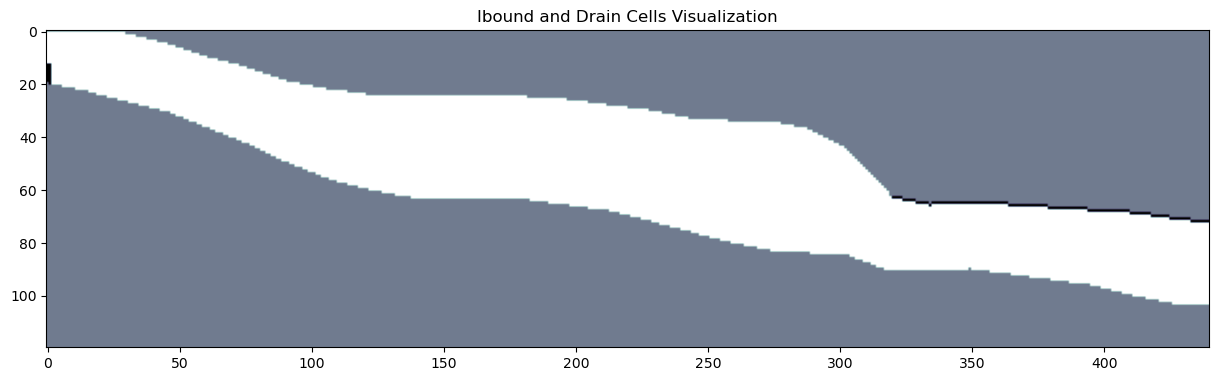

In [ ]:
# Load your model
model = mf
# Plot the ibound array
plt.imshow(model.bas6.ibound.array[:, :, 0], origin='upper', cmap='bone')
# Plot drains for the first stress period if DRN package exists
if model.drn:
    for drn in np.unique(model.drn.stress_period_data[0], axis=0):
        if drn[2] == 0:  # Checks if the drain is in the first layer
            plt.scatter(drn[1], drn[0], c='cyan', s=5, marker='s')

# Customize and display the plot
plt.gcf().set_size_inches(15, 10)
plt.title('Ibound and Drain Cells Visualization')
# plt.xlim(140,175)
# plt.ylim(60,20)
plt.show()


# RCH

In [ ]:
septic_gw_flux = 0.51 #  0.51m3/D per septic system

### Test data

In [ ]:
##2D pers [1]+[30,92,31,212]*25 +[365]*5+[365*5]*5+[365*4]+[185,30,30,120]

In [ ]:
# rch_dict = {}

# rch_array = np.full(( nrow, ncol), 0.00013, dtype=float)
# rch_dict[0] = rch_array

# rch_array = np.full(( nrow, ncol), 0.00013, dtype=float)
# #rch_array[int(nrow/2),int(ncol/2)] = 0.51/delr/delc
# #rch_array[int(nrow/2),int(ncol/3)] = 0.51/delr/delc

# rch_array[int((1700-70)/delr),int(ncol/2)] = 0.51/delr/delc
# rch_array[int((1700-70)/delr),int(ncol/3)] = 0.51/delr/delc
# rch_dict[1] = rch_array 


# rch_array = np.full(( nrow, ncol), 0.00013, dtype=float)
# rch_dict[26] = rch_array


# rch = flopy.modflow.ModflowRch(model = mf, rech = rch_dict)

In [ ]:
import pandas as pd

model_begin_year = 1950
def calculate_year_septic_start(df):
    # Ensure the DataFrame is sorted by 'Year'
    df = df.sort_values('Year').reset_index(drop=True)
    
    # Get the unique years and sort them
    unique_years = sorted(df['Year'].unique())
    
    # Initialize the "Year_Septic_Start" list
    year_septic_start = []
    
    # Iterate through the DataFrame rows
    for current_year in df['Year']:
        # Find the index of the current_year in the unique_years list
        current_index = unique_years.index(current_year)
        
        # Determine the previous year (if it's not the first year)
        if current_index == 0:
            #previous_year = 1950  # If it's the first unique year, use 1950
            year_septic_start.append(model_begin_year )
        else:
            previous_year = unique_years[current_index - 1]  # Get the previous unique year
        
        # Calculate the "Year_Septic_Start"
            year_septic_start.append((current_year + previous_year) // 2)
    
    # Add the "Year_Septic_Start" as a new column in the DataFrame
    df['Year_Septic_Start'] = year_septic_start
    return df

df = pd.read_csv("wasaga septics placement/septics_transformed.csv")
df = df[~df['Year End'].isna()]
df['Year End'] =df['Year End'].astype(int)
df = calculate_year_septic_start(df)
df['Year_Septic_End'] = df['Sewer_Installation_Period'].apply(lambda x: (int(x.split('-')[1]) + int(x.split('-')[0]))//2)

In [ ]:
# Assuming necessary variables (shoreline_distance, delr, ncol, nrow, nlay, ibound) are defined
start_dis_1 = shoreline_distance - 150
end_dis_1 = shoreline_distance - 60

In [ ]:
import numpy as np
import flopy  # Assuming flopy is already installed and imported

# Assuming nrow, ncol, delr, delc, mf are defined earlier in your code
# Define start_dist, end_dist, and exclude_range
start_dist = start_dis_1 -100  # Define start distance for exclusion (e.g., 1000 meters)
end_dist = end_dis_1    # Define end distance for exclusion (e.g., 2000 meters)
exclude_range = False  # Set to True to exclude, False to include

# Convert distances to row indices
start_row_index = int(start_dist / delr)
end_row_index = int(end_dist / delr)

# Initialize the recharge dictionary
rch_dict = {0: np.full((nrow, ncol), 0.00013, dtype=float)}  # Initial background recharge rate
# for kper in range(nper-1):
#     rch_dict = {kper: np.full((nrow, ncol), 0.00013, dtype=float)} 

# Loop through the DataFrame to update rch_dict
for index, row in df.iterrows():
    easting = row['Wasaga Easting']
    northing = row['Wasaga Northing']
    start_year = row['Year_Septic_Start']
    end_year = row['Year_Septic_End']

    # Calculate the indices
    row_index = int(northing / delr)
    col_index = int(easting / delc)

    # Check if row index is within the exclusion range and if exclusion is enabled
    if exclude_range and start_row_index <= row_index <= end_row_index:
        continue  # Skip updating for this row index

    # Calculate the range of years for each septic source
    start_key = start_year - model_begin_year + 1
    end_key = end_year - model_begin_year  + 1

    # Loop through each year for the septic source
    for year_key in range(start_key, end_key + 1):
        # Check if the key exists in the dictionary, if not, create a new array with background recharge
        if year_key not in rch_dict:
            rch_dict[year_key] = np.full((nrow, ncol), 0.00013, dtype=float)

        # Update the recharge rate at the septic location
        rch_dict[year_key][row_index, col_index] = septic_gw_flux / delr / delc
    
    # Ensure the septic is turned off after its end year
    if end_key + 1 not in rch_dict:
        rch_dict[end_key + 1] = np.full((nrow, ncol), 0.00013, dtype=float)

    # Set the recharge rate back to the background rate after the septic system's active period
    rch_dict[end_key + 1][row_index, col_index] = 0.00013

# Create the ModflowRch object
rch = flopy.modflow.ModflowRch(model=mf, rech=rch_dict)


In [ ]:
# # Assuming 'mf' is your MODFLOW model and 'rch_dict' is a dictionary with stress period numbers as keys and recharge arrays as values

# # Number of stress periods in your model
# nper = mf.nper

# # Initialize an empty dictionary for the new, gradually changing recharge rates
# new_rch_dict = {}

# # Use linear interpolation to fill in recharge rates for each stress period
# for per in range(nper):
#     if per in rch_dict:
#         # If the current period is in the original dictionary, use its value
#         new_rch_dict[per] = rch_dict[per]
#     else:
#         # Find the nearest periods before and after the current period that have specified recharge rates
#         before = max([p for p in rch_dict if p < per], default=None)
#         after = min([p for p in rch_dict if p > per], default=None)

#         if before is not None and after is not None:
#             # If there are specified periods both before and after, interpolate recharge rates
#             weight = (per - before) / (after - before)
#             new_rch_dict[per] = (1 - weight) * rch_dict[before] + weight * rch_dict[after]
#         elif before is not None:
#             # If only a before period is found, use its recharge rate
#             new_rch_dict[per] = rch_dict[before]
#         elif after is not None:
#             # If only an after period is found, use its recharge rate
#             new_rch_dict[per] = rch_dict[after]

# # Create the RCH package with the new recharge dictionary
# rch = flopy.modflow.ModflowRch(model=mf, rech=new_rch_dict)

In [ ]:
model.drn

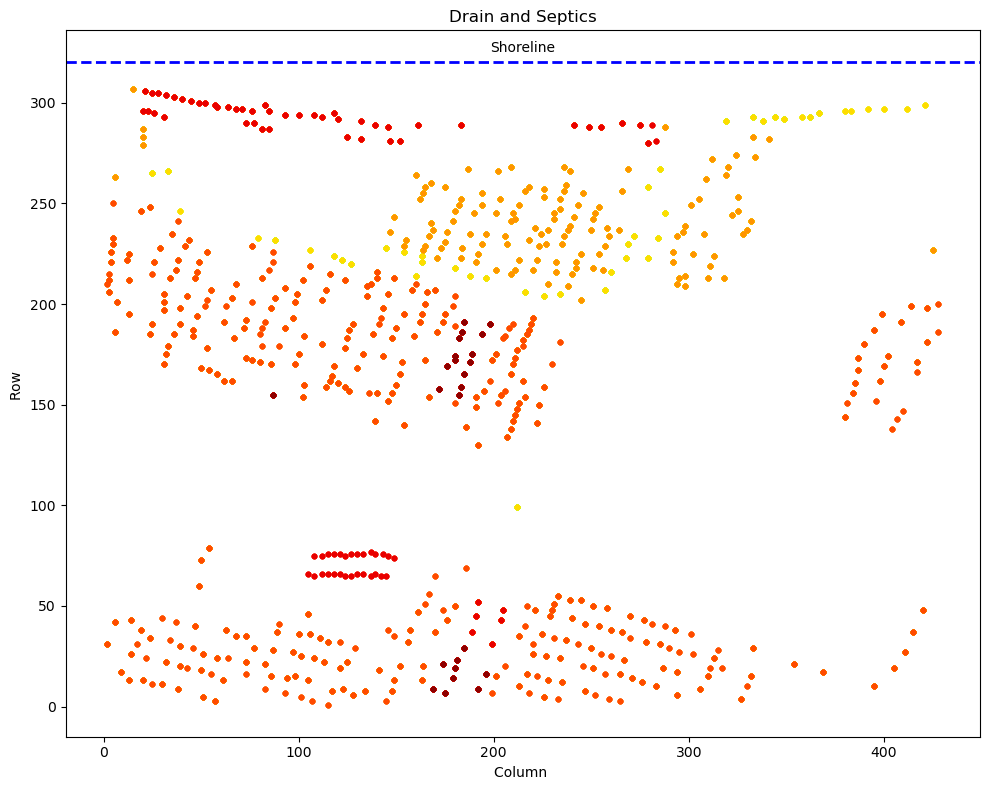

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

# Plot drain coordinates
if model.drn:
    rows = []
    cols = []
    for drn in np.unique(model.drn.stress_period_data[0], axis=0):
        rows.append(drn[1])
        cols.append(drn[2])

    ax.scatter(cols, rows, c='cyan', marker='s')

# Plot and customize the shoreline as a thicker, dashed line and add annotation
shoreline_y = shoreline_distance / delr
ax.axhline(shoreline_y, color='blue', linestyle='--', linewidth=2, label='Shoreline')
ax.annotate('Shoreline', xy=(0.5, shoreline_y), xytext=(0, 5),
            xycoords=('axes fraction', 'data'), textcoords='offset points',
            ha='center', va='bottom')

# Assuming rch_dict, delr, and delc are already defined
target_value = 0.51 / delr / delc
colors = plt.cm.jet(np.linspace(0, 1, len(rch_dict)))

for (key, array), color in zip(rch_dict.items(), colors):
    rows, cols = np.where(np.isclose(array, target_value))
    if rows.size and cols.size:
        ax.scatter(cols, rows, color=color, label=f'Key: {key}',s=10)

# Set titles and labels
ax.set(title='Drain and Septics', xlabel='Column ', ylabel='Row ')

# Display legend
#ax.legend()
# plt.xlim(0,440)
# plt.ylim(280,320)

plt.tight_layout()
plt.show()


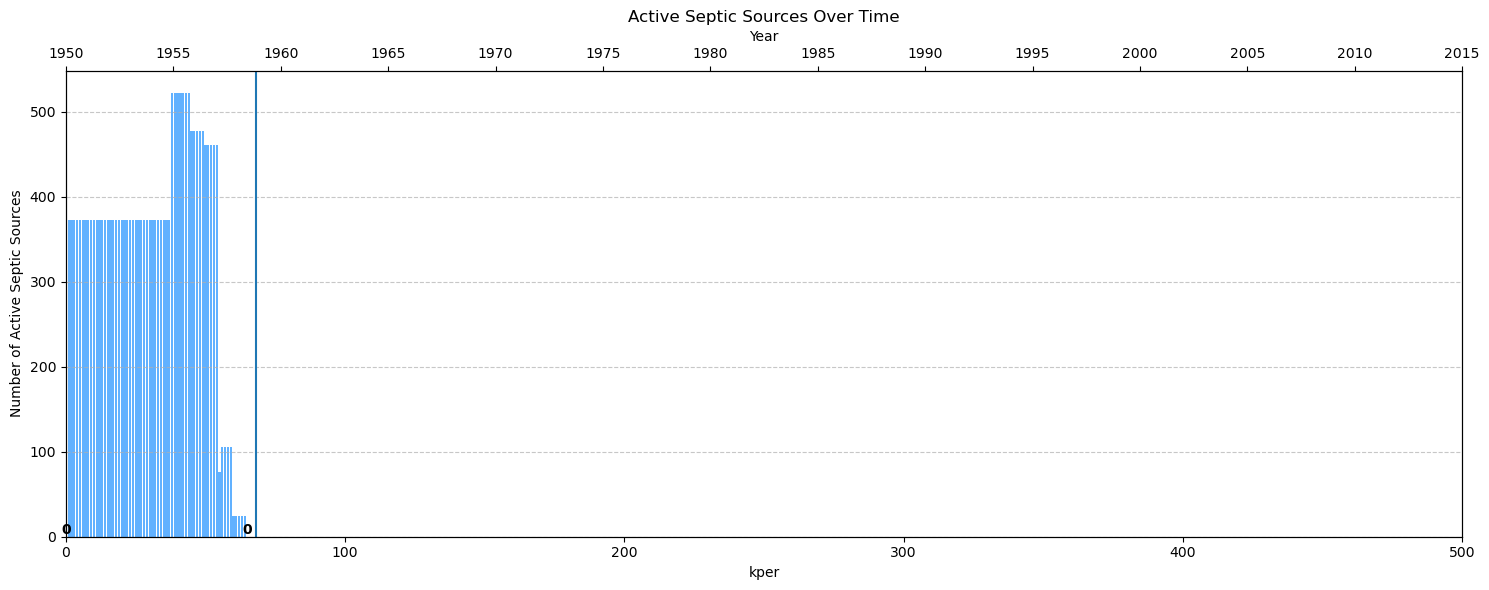

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming rch_dict, delr, and delc are defined elsewhere and model_begin_year is provided

# Calculate and plot in a compact form
kpers, active_septics = zip(*sorted((year_key, np.sum(rech >= septic_gw_flux / delr / delc)) for year_key, rech in rch_dict.items()))

fig, ax1 = plt.subplots(figsize=(15, 6))
bars = ax1.bar(kpers, active_septics, color='dodgerblue', alpha=0.7)

ax1.set(xlabel='kper', ylabel='Number of Active Septic Sources', title='Active Septic Sources Over Time')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(x=68)

# Adding secondary x-axis on top
ax2 = ax1.twiny()  # Create a twin Axes sharing the y-axis

# Decide on the number of ticks: for example, one tick every 5 ticks from the original x-axis
tick_spacing = 5
selected_ticks = kpers[::tick_spacing]
selected_labels = [str(x + model_begin_year) for x in selected_ticks]
ax1.set_xlim(0,nper)

ax2.set_xticks(selected_ticks)
ax2.set_xticklabels(selected_labels)
ax2.set_xlabel('Year')  # Set label for the secondary x-axis

# Annotate bars with values
for bar, val in zip(bars, active_septics):
    if val == 0: 
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


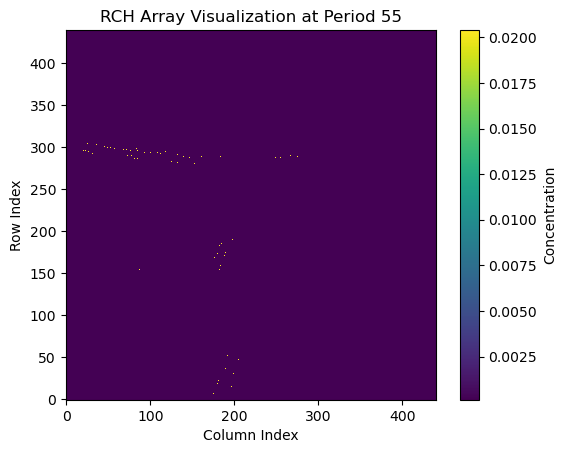

In [ ]:
import matplotlib.pyplot as plt

# Assuming crch_dict is already defined and filled with your data

period = max(rch_dict.keys()) - 10  # Specify the period you want to visualize
if period in rch_dict: 
    crch_array = rch_dict[period]
    plt.imshow(crch_array, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Concentration');plt.gca().invert_yaxis()
    plt.xlabel('Column Index'); plt.ylabel('Row Index'); plt.title(f'RCH Array Visualization at Period {period}');plt.show()
else: print(f"No data available for period {period}")


# OC

In [ ]:
# OC
spd = {}
for kper in range(nper):
    for kstp in range(1):
        spd[(kper, kstp)] = [
            "save head",
            "save drawdown",
            "save budget",
            "print head",
            "print budget",
        ]

oc = flopy.modflow.ModflowOc(
    mf,
    stress_period_data= spd,
    compact=True
    ,extension=['oc', 'hds', 'ddn', 'cbc', 'ibo']
)

#oc.reset_budgetunit(budgetunit=1053, fname='test.cbc')
oc.reset_budgetunit(budgetunit=53, fname='example_model.cbc')

In [ ]:
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='mt3d_link.ftl')

In [ ]:
open_file(model_ws)
Path(model_ws)

WindowsPath('H:/mf/_T0212001531__Soft_Heart')

In [ ]:
# Write the MODFLOW model input files
mf.write_input()

In [ ]:
# Run the MODFLOW model
success, buff = mf.run_model()

FloPy is using the following executable to run the model: C:\Users\Administrator\AppData\Local\flopy\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: example_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/02/12  0:18:55

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress perio

# ---MT3DMS---

In [ ]:
mt = flopy.mt3d.Mt3dms(modflowmodel=mf, modelname='mt', exe_name='mt3dms.exe' ,ftlfilename='mt3d_link.ftl',model_ws=model_ws)

# ICBUND

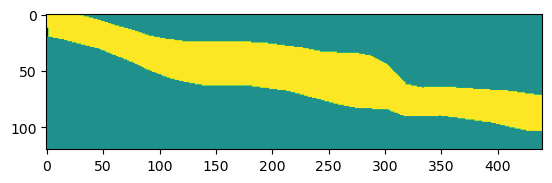

In [ ]:
icbund = ibound.copy()
cc = np.where(icbund==-1)
mask = cc[1]>2200/2/delr

cc2 = (cc[0][mask],cc[1][mask],cc[2][mask])
icbund[cc2] = 1
plt.imshow(icbund[:,:,0])

# BTN ICBOUND 

In [ ]:
#icbund = np.full((nlay, nrow, ncol),0, dtype=float)
#
btn = flopy.mt3d.Mt3dBtn(
    mt,
    nprs=5,
    timprs=np.cumsum([200]*7),
    prsity=0.25,
    sconc= 0.01, # starting concentration
    ifmtcn=0, chkmas=False, nprobs=10, nprmas=10,
    dt0=5,  # The user-specified initial 
    ttsmult=1.4,
    mxstrn = 50000,
    icbund = icbund
)


In [ ]:
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=0,percel=0.4,mxpart=50000000,nadvfd=0)
dsp = flopy.mt3d.Mt3dDsp(mt, al=parms['al'], trpt=0.1, 
                        trpv=0.01, 
                        dmcoef=3.7E-10 )  ## !!TRVP change to 0.01
gcg = flopy.mt3d.Mt3dGcg(mt, iter1=50, mxiter=1, isolve=2, cclose= 1e-5)

# RCH

In [ ]:
# crch_array =  np.full(( nrow, ncol), 0.1, dtype=float)
# crch_dict = {}
# crch_dict[0] = crch_array
# ssm = flopy.mt3d.Mt3dSsm(model, crch=crch_dict)

# rch_dict = {}
# rch_array = np.full(( nrow, ncol), 0.00013, dtype=float)
# rch_dict[0] = rch_array
# rch = flopy.modflow.ModflowRch(model = model, rech = rch_dict)


# ## [row, col, rch(m3), crch, start, end]
# rch_data = [[1100,1100,0.51,5000,1,20]]


### Real Septics

In [ ]:
# import numpy as np
# import pandas as pd
# import flopy

# # Assuming nrow, ncol, delr, delc, and mt are defined earlier in your code

# # Initialize the base concentration array and the dictionary
# crch_array_base = np.full((nrow, ncol), 0.01, dtype=float)
# crch_dict = {0: crch_array_base.copy()}

# # Read the CSV file from the specified path
# df = pd.read_csv("wasaga septics placement/septics_transformed.csv")
# df = df[~df['Year End'].isna()]
# df['Year End'] =df['Year End'].astype(int)

# # Loop through the DataFrame to update crch_dict
# for index, row in df.iterrows():
#     easting = row['Wasaga Easting']
#     northing = row['Wasaga Northing']
#     start_year = row['Year']
#     end_year = row['Year End']

#     # Calculate the indices
#     row_index = int(northing / delr)  # Using northing for row index
#     col_index = int(easting / delc)   # Using easting for column index

#     # Calculate the range of years for each septic source
#     start_key = start_year - 1968
#     end_key = end_year - 1968

#     # Loop through each year for the septic source
#     for year_key in range(start_key, end_key + 1):
#         # Check if the key exists in the dictionary, if not, create a new array
#         if year_key not in crch_dict:
#             crch_dict[year_key] = crch_array_base.copy()

#         # Update the concentration at the specified location
#         crch_dict[year_key][row_index, col_index] = 5000  # or any other value you wish to set

# # Create the SSM object
# ssm = flopy.mt3d.Mt3dSsm(mt, crch=crch_dict)


In [ ]:
import numpy as np
import pandas as pd
import flopy

# Assuming nrow, ncol, delr, delc, and mt are defined earlier in your code
# Also assuming rch_dict is already defined from your MODFLOW recharge setup

# Initialize the base concentration array and the dictionary
crch_array_base = np.full((nrow, ncol), 0.01, dtype=float)  # Background concentration
crch_dict = {}

# Constants for recharge and concentration
background_recharge = 0.00013
septic_recharge = 0.51 / delr / delc
background_concentration = 0.01
septic_concentration = 5000

# Loop through each stress period in rch_dict
for stress_period, rch_array in rch_dict.items():
    # Copy the base concentration array for the current stress period
    crch_array = crch_array_base.copy()
    
    # Find indices where recharge rate indicates a septic source
    septic_indices = np.where(rch_array == septic_recharge)
    
    # Update the concentration array at these indices
    crch_array[septic_indices] = septic_concentration
    
    # Store the updated concentration array in crch_dict for the current stress period
    crch_dict[stress_period] = crch_array

# Create the SSM object using crch_dict
ssm = flopy.mt3d.Mt3dSsm(mt, crch=crch_dict)


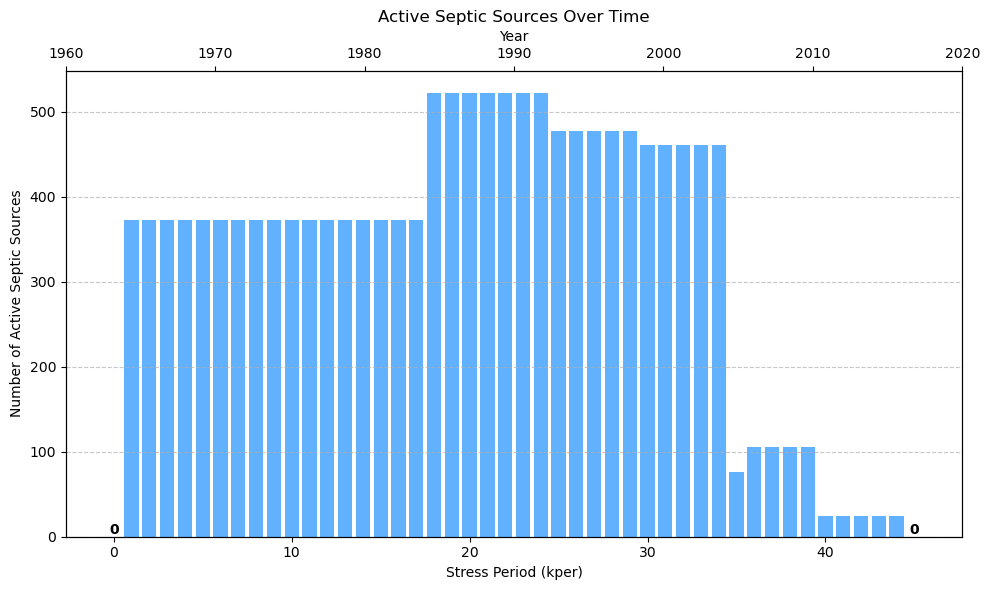

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Constants for recharge and concentration
septic_concentration = 5000

# Calculate and plot in a compact form
kpers, active_septics = zip(*sorted((year_key, np.sum(crch == septic_concentration)) for year_key, crch in crch_dict.items()))

fig, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(kpers, active_septics, color='dodgerblue', alpha=0.7)

ax1.set(xlabel='Stress Period (kper)', ylabel='Number of Active Septic Sources', title='Active Septic Sources Over Time')

# Adjust the x-axis to show actual years assuming the first stress period starts in 1950 (change if needed)
start_year =model_begin_year 
ax2 = ax1.twiny()
ax2.set(xlabel='Year', xlim=[start_year + kpers[0], start_year + kpers[-1]], xticks=[start_year + k for k in ax1.get_xticks()],
        xticklabels=[int(start_year + k) for k in ax1.get_xticks()])
ax1.grid(axis='y', linestyle='--', alpha=0.7)



# Add text labels on the bars
for bar, val in zip(bars, active_septics):
    if val == 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')



plt.axvline(x=48)

plt.tight_layout()
plt.show()


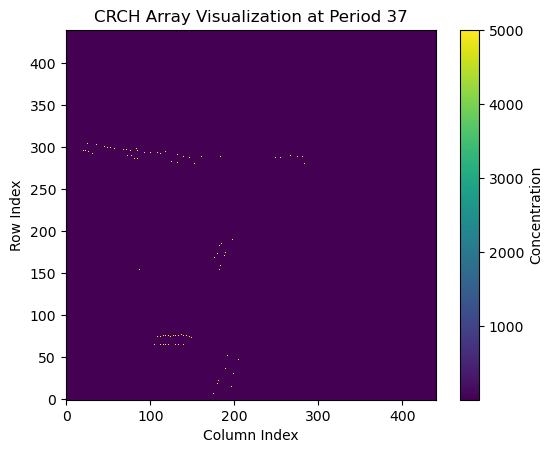

In [ ]:
import matplotlib.pyplot as plt

# Assuming crch_dict is already defined and filled with your data

period = 37  # Specify the period you want to visualize

# Check if the period exists in the dictionary
if period in crch_dict:
    # Extract the array for the specified period
    crch_array = crch_dict[period]

    # Create a heatmap of the array
    plt.imshow(crch_array, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Concentration')  # Add a color bar to indicate the values

    # Flip the y-axis
    plt.gca().invert_yaxis()

    # Add labels and title
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.title(f'CRCH Array Visualization at Period {period}')

    # Show the plot
    plt.show()
else:
    print(f"No data available for period {period}")


### Test SSM

In [ ]:
# crch_array =  np.full(( nrow, ncol), 0.01, dtype=float)
# crch_dict = {}
# crch_dict[0] = crch_array

# crch_array =  np.full(( nrow, ncol), 0.01, dtype=float)

# # crch_array[int(nrow/2),int(ncol/2)] =5000
# # crch_array[int(nrow/2),int(ncol/3)] =5000
# crch_array[int((1700-70)/delr),int(ncol/3)] =5000
# crch_array[int((1700-70)/delr),int(ncol/2)] =5000
# spetic_locs = [[int((1700-70)/delr),int(ncol/3)], [int((1700-70)/delr),int(ncol/2)]]

# crch_dict = {}
# crch_dict[1] = crch_array


# crch_array =  np.full(( nrow, ncol), 0.01, dtype=float)
# crch_dict[26] = crch_array

# ssm = flopy.mt3d.Mt3dSsm(mt, crch=crch_dict)

# RCT

In [ ]:
rct = flopy.mt3d.Mt3dRct(model=mt, isothm=3,sp1=parms['sp1'],sp2=0.0001,igetsc=0,rhob= 1.65E+09)

# Write and Run

In [ ]:

# Write MODFLOW input files
mt.write_input()

In [ ]:
open_file(model_ws)

In [ ]:
# Run the MODFLOW model
mt.run_model()

FloPy is using the following executable to run the model: C:\Users\Administrator\AppData\Local\flopy\bin\mt3dms.exe
 MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.30]
 Developed at University of Alabama for U.S. Department of Defense

 Using NAME File: mt.nam                                            



 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    365.00    

 Transport Step:    1   Step Size:   5.000     Total Elapsed Time:   5.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:    2   Step Size:   7.000     Total Elapsed Time:   12.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:    3   Step Size:   9.800     Total Elapsed Time:   21.800    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:    4   Step Size:   13.72     Total Elapsed Time:   35.520    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:    5   Step Size:   19.21     Total Elapsed Time:   54.728    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:    6   Step Size:   26.89     Total Elapsed Time:   81.619    
 Outer Iter.  1  Inner Iter.  

(False, [])

In [ ]:
model_ws

'H:/mf/_T0208024128__Cowardly_Bird'